<a href="https://colab.research.google.com/github/hyunjimoon/robust_optimization/blob/master/src/SPEO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# questions
#### Implementation
## policy.py 
`argmin_l_pred's MClass`
1. Can you give me some example of model class other than linear? 
2. Unlike Adam's previous comment on $y \sim N(\theta' X'X, 1)$ `quad` could be elementwise power $X^2 (n*p)$? (vs $X'X (p*p)$)
3. How to improve grid search of theta in approach2?

#### Experiment design
1. Is misspecification type2 needed? What advantage would approach 2 have?

#### Theory
1. Could approach1 also be thought as empirical risk minization? As the solution depends on the dataset (x_i, y_i) at $\theta_1$ estimation level, I think it could be. Is this is why you used $\hat{w}$, not $w*$, Henry?
2. Is it awkward to express the cost funciton as $l_{opt}$? Thought the input is w, y underneath, it could be implicitly rearranged as function of $\hat{\theta}, \theta$.
3. Does having a feature related to parameteric optimization?
4. $H_\theta := P_\theta()$ is this notation correct?
5. Is Remark2 (P(.) combinatorial/MIP) from SPO paper applicable for approach2? 
$w^{∗}(c) \in \underset{w \in \tilde{S}}{argmin} l_{opt}(w, y)⊆ \underset{w \in S}{argmin} l_{opt}(w, y)$ where S, $\tilde{S}$ are feasible set and its closed convex hull.

In [1]:
# allow R
%load_ext rpy2.ipython
# test RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')
# mount drive
#RERUN THIS CELL ARTER .py EDIT!)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# required install (the rest is preinstalled)
!pip install cmdstanpy==0.9.77
#fast cmdstanpy install
# (faster than compiling from source via install_cmdstan() function)
# tgz_file = 'colab-cmdstan-2.23.0.tar.gz'
# tgz_url = 'https://github.com/stan-dev/cmdstan/releases/download/v2.23.0/colab-cmdstan-2.23.0.tar.gz'
# if not os.path.exists(tgz_file):
#     urllib.request.urlretrieve(tgz_url, tgz_file)
#     shutil.unpack_archive(tgz_file)

import sys
import matplotlib.pyplot as plt
import json
import os
import numpy as np
import pandas as pd
import itertools
import cmdstanpy
from matplotlib import pyplot as plt
sys.path.append('/content/drive/MyDrive/Colab Notebooks/robust_optimization/src')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!
Mounted at /content/drive


In [10]:
# newly implemented in src/python
from generator import generator, normal_dist, unif_dist
from policy import argmin_lopt_gen, argmin_lopt_bar_argmin_lpred, argmin_lopt_emp, argmin_lpred
from loss import lopt_NV

Two misspecification types on degree and distribution.
```
def generator(theta_star, sigma_x, sigma_y, degree, dist, n):
    '''
    Generate data of 1.ground truth (deg=1, norm_dist), 2.(deg>1, norm_dist), 
                     3.(deg = 1, !norm_dist), 3.(deg > 1, !norm_dist)

    Parameters:
        array theta_star: true parameter value
        array sigma_x: array of length p, is the variance of each feature vector dimension, i.e. x_i ~ N(0, sigma_p)
        float sigma_y: noise of outcome sampled as N(y_true, sigma_y)
        int degree: `y_ture|x` str.  #MISSPEC1 degree 1 vs >1
                    y_true = x-linear if degree =1, polynomial degree prop.to amount of model misspecification
        chr dist: `y|y_ture` str. #MISSPEC2 normal_dist vs unif_dist, t_dist, gamma_dist, (TODO mm_dist)
        int n: number of data points to generate
        # x \sim N(0, sigma_x)
        # y|x \sim N(y_true, sigma_y)
        # (x,y) \sim Normal(??)
    Returns:
        np.array X: predictor data of dimension [n, p]
        np.array y: outcome data of dimension [n, 1] = (1,p) * (p, n)
    '''
    # metadata
    p = len(theta_star)
    # Generate predictor: iid MVN with each ith col. predictors share `sigma_x[i]`
    X = np.random.normal(loc = 0, scale = sigma_x, size = [n, p]) # each row is a training point of size p
    def normal_dist(mu,sd, n):
      return np.random.normal(mu, sd, size = n)
    def unif_dist(mu, sd, n):
      return np.random.uniform(mu - np.sqrt(3)*sd, mu + np.sqrt(3)*sd, n)
    if dist == 'unif':
      ys = [P(theta_star @ np.power(X, d).T, np.repeat(sigma_y, n), n) for P in (normal_dist, unif_dist) for d in (1, degree)]
    return X, ys

```

In [3]:
# metadata
np.random.seed(1)
MClass = "lin"
p, c, s = 5, 1, 0
n = 100
p = 2
sigma_x = [1, 1]
sigma_y = .1
theta_star = np.repeat(2, p)

X, ys  = generator(theta_star, sigma_x, sigma_y, 3, 'unif', n)
df = pd.DataFrame(ys).transpose()
df.columns = ['yw','ym1','ym2','ym12']
df['X1'] = X[:,0]
df['X2'] = X[:,1]


In [4]:
df

,yw,ym1,ym2,ym12,X1,X2
0,1.985090,8.320347,2.031765,7.995932,1.624345,-0.611756
1,-3.119880,-2.912334,-3.314961,-2.868240,-0.528172,-1.072969
2,-2.928493,-23.169628,-2.847765,-23.110450,0.865408,-2.301539
3,2.162698,9.653499,2.139290,9.708372,1.744812,-0.761207
4,0.006142,0.006023,0.249092,-0.088436,0.319039,-0.249370
...,...,...,...,...,...,...
95,3.029926,3.304869,3.206352,3.214070,1.160339,0.369493
96,6.073161,16.374920,6.102809,16.498069,1.904659,1.111057
97,-1.858300,-7.956148,-1.944387,-8.004266,0.659050,-1.627438
98,1.949660,0.581967,1.915718,0.716225,0.602319,0.420282


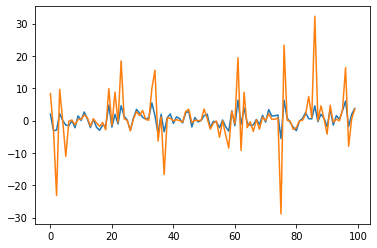

In [5]:
plt.plot(df.iloc[:,[0,1]])

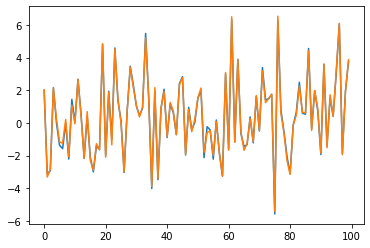

In [6]:
# negligible bc sigma_y is small (.1)
plt.plot(df.iloc[:,[0,2]])

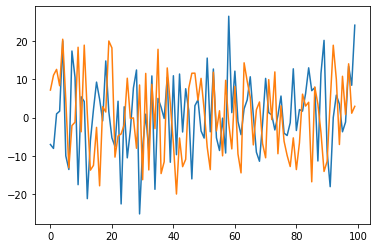

In [7]:
sigma_y = 10
X2, ys2  = generator(theta_star, sigma_x, sigma_y, 3, 'unif', 100)
df2 = pd.DataFrame(ys2).transpose()
plt.plot(df2.iloc[:,[0,2]])

In [ ]:
def P_ybarx(theta, x, n_gen = 10):
  return np.random.normal(loc = theta @ x, scale = 1, size = n_gen)
yw = np.array(df.yw)  
df['what1']= argmin_lopt_bar_argmin_lpred(MClass, P_ybarx, yw, X) #MClass = "lin"
df['what2']= argmin_lopt_emp(P_ybarx, yw, X)

#Future work!
# df['what1_m']= argmin_lopt_bar_argmin_lpred(MClass, P_ybarx, yw, X) #MClass = "lin"
# df['what2_m']= argmin_lopt_emp(P_ybarx, ym, X)

In [57]:
df

,yw,ym1,ym2,ym12,X1,X2,what1,what2
0,1.985090,8.320347,2.031765,7.995932,1.624345,-0.611756,3.08738,3.10749
1,-3.119880,-2.912334,-3.314961,-2.868240,-0.528172,-1.072969,-2.84184,-3.98296
2,-2.928493,-23.169628,-2.847765,-23.110450,0.865408,-2.301539,-2.33333,-2.20410
3,2.162698,9.653499,2.139290,9.708372,1.744812,-0.761207,2.56505,2.96988
4,0.006142,0.006023,0.249092,-0.088436,0.319039,-0.249370,0.94508,1.05078
...,...,...,...,...,...,...,...,...
95,3.029926,3.304869,3.206352,3.214070,1.160339,0.369493,4.30566,5.09610
96,6.073161,16.374920,6.102809,16.498069,1.904659,1.111057,7.02934,8.01060
97,-1.858300,-7.956148,-1.944387,-8.004266,0.659050,-1.627438,-1.64655,-1.56307
98,1.949660,0.581967,1.915718,0.716225,0.602319,0.420282,3.58180,3.10389


```
def lopt_NV(w, y, profit, cost):
    '''
    Compute optimization loss (a.k.a cost function)
    Parameters:
        real w: decision e.g. inventory amount
        real y: outcome e.g. demand
        real profit
        real cost
    Returns:
        real: objective value, $l_opt(W(thetahat, X), y)$
    '''
    return - (profit * min(w, y) - cost * w)
  ```

In [97]:
print(np.mean([- (profit * min(w, y) - cost * w) for w, y in zip(df.yw, df.what1)]))
print(np.mean([- (profit * min(w, y) - cost * w) for w, y in zip(df.yw, df.what2)]))
#-0.42443076171522115
#-0.32726932281156307

-0.42443076171522115
-0.32726932281156307


Approach1 is better when well-specified.

## Misspecified
True dgp is nonlinear but the model class and P_ybarx is linear.
use ym1 generated with degree > 1 of x.
Approach2 is better when degree is missepcified. Note that current $\theta$ search for approach 2 is nonoptimal as the grid search range and step is limited from 1 to 3 and .5 (true:2); the loss for the second approach can improve.
```
# approach 2
def argmin_lopt_emp(P_ybarx, y, X):
    '''
    Compute approach2 optimal solution; empirical objective minimization
    Parameters:
        function P_ybarx: simulator function given X and theta, outputs y
        array y: outcome data of size [n, 1]
        array X: predictor data of size [n, p] 
    Returns:
        array what: optimal solution for each x of size [n,1]
    '''
    # DO NOT CONFUSE THE TWO
    # what_x (\hat{w}(\theta, x_i))
    # what (\hat{w}(\hat{\theta_2}, x))
    theta1 = np.arange(1, 3, 0.5)
    theta2 = np.arange(1, 3, 0.5)
    theta1, theta2 = np.meshgrid(theta1, theta2)
    profit, cost = 5, 1
    M = 1000000
    for theta in zip(theta1.ravel(), theta2.ravel()):
      loss = 0
      for i in range(len(X)):
        what_x = argmin_lopt_gen(P_ybarx, theta, X[i])
        loss -= (profit * min(what_x, y[i]) - cost * what_x)
      if loss < M:
        thetahat2 = theta
    what = np.repeat(np.nan, len(X))
    for i in range(len(X)):
        what[i] = argmin_lopt_gen(P_ybarx, thetahat2, X[i])
    return what
```

In [ ]:
ym1 = np.array(df.ym1)
df['what1_m']= argmin_lopt_bar_argmin_lpred(MClass, P_ybarx, yw, X) #MClass = "lin"
df['what2_m']= argmin_lopt_emp(P_ybarx, ym1, X)
print(np.mean([-(profit * min(w, y) - cost * w) for w, y in zip(df.ym1, df.what1_m)]))
print(np.mean([-(profit * min(w, y) - cost * w) for w, y in zip(df.ym1, df.what2_m)]))
#3.233612485805617
#2.951143204488013

In [ ]:
# Future work. Distribution misspecification
ym2 = np.array(df.ym2)
df['what1_m2']= argmin_lopt_bar_argmin_lpred(MClass, P_ybarx, ym2, X) #MClass = "lin"
df['what2_m2']= argmin_lopt_emp(P_ybarx, ym2, X)
print(np.mean([-(profit * min(w, y) - cost * w) for w, y in zip(df.ym2, df.what1)]))
print(np.mean([-(profit * min(w, y) - cost * w) for w, y in zip(df.ym2, df.what2)]))

## Main code for plugin optimizer, approach 1, 2

```
## 2. Policies with given predictors (supervised)
# plug-in opt.solver
def argmin_lopt_gen(P_ybarx, theta, x):
    '''
    Compute optimal solution for each theta and X assuming $Y|X \sim P_{\theta}$
    Parameters:
        function P_ybarx: given x, theta, simulate y vector (should be len(y)>1)
        array theta: model parameter of size [p, 1]
        array x: predictor data of size [1, p] 
        function lopt: loss function, given w(x), y, X, outputs loss
    Returns:
        array w: optimal solution for each x of size [n,1]
    '''
    y_sim = P_ybarx(theta, x, n_gen = 10)
    profit, cost = 5, 1 #todo **kwargs.args()
    data = {'y': list(y_sim), 'n': len(y_sim), 'profit': profit, 'cost': cost} 
    sm = cmdstanpy.CmdStanModel(stan_file="/content/drive/MyDrive/Colab Notebooks/robust_optimization/src/stan/optW_lopt_NV.stan") 
    what = sm.optimize(data).stan_variable('w')
    return what

# approach 1
def argmin_lopt_bar_argmin_lpred(MClass, P_ybarx, y, X, alg_type = "sample"):
    '''
    Compute approach1 optimal solution; separate predict optimize
    Parameters:
         char MClass: model class type specificed with `P_ybarx`
            "lin": y_true = theta' * X
            "quad": y_true = theta' * X^2
          np.array y: outcome data of size [n, 1]
          np.array X: predictor data of size [n, p] 
          chr alg_type: Solver algorithm
    Returns:
        np.array what: predict then optimize optimal solution of size [n,1]
    '''
    thetahat1 = argmin_lpred(MClass, y, X, alg_type = alg_type)
    what = np.repeat(np.nan, len(X))
    for i in range(len(X)):
        what[i] = argmin_lopt_gen(P_ybarx, thetahat1, X[i])
    return what

# approach 2
def argmin_lopt_emp(P_ybarx, y, X):
    '''
    Compute approach2 optimal solution; empirical objective minimization
    Parameters:
        function P_ybarx: simulator function given X and theta, outputs y
        array y: outcome data of size [n, 1]
        array X: predictor data of size [n, p] 
    Returns:
        array what: optimal solution for each x of size [n,1]
    '''
    # DO NOT CONFUSE THE TWO
    # what_x (\hat{w}(\theta, x_i))
    # what (\hat{w}(\hat{\theta_2}, x))
    theta1 = np.arange(1, 3, 0.5)
    theta2 = np.arange(1, 3, 0.5)
    theta1, theta2 = np.meshgrid(theta1, theta2)
    profit, cost = 5, 1
    M = 1000000
    for theta in zip(theta1.ravel(), theta2.ravel()):
      loss = 0
      for i in range(len(X)):
        what_x = argmin_lopt_gen(P_ybarx, theta, X[i])
        loss -= (profit * min(what_x, y[i]) - cost * what_x)
        #lopt_NV(what, y[i], profit, cost) 'numpy.float64' object cannot be interpreted as an integer
      if loss < M:
        thetahat2 = theta
    what = np.repeat(np.nan, len(X))
    for i in range(len(X)):
        what[i] = argmin_lopt_gen(P_ybarx, thetahat2, X[i])
    return what

def argmin_lpred(MClass, y, X, alg_type = "sample"):
    '''
    Solve parameter that best predicts y given X assuming $y\sim N(X * theta, 1)$
    Parameters:
        char MClass: model class type specificed with `P_ybarx` which is user-defined 
             input for `argmin_lopt_gen`, `argmin_lopt_emp` 
             SHOULD comply with "P_ybarx_f{MClass}.stan"
             "lin": y_true = theta' * X
             "quad": y_true = theta' * X^2
        np.array y: outcome data of size [n, 1]
        np.array X: predictor data of size [n, p] 
        chr alg_type: Solver algorithm
             "sample": MAP with improper uniform priors (undeclared) in stan file with HMC
             "optimize": Maximum likelihood estimate () with "lbfgs", "bfgs", "newton"  
             "varaiational": variational inference with ADVI, RVI
             https://mc-stan.org/cmdstanpy/examples/Maximum%20Likelihood%20Estimation.html
             https://mc-stan.org/cmdstanpy/examples/Variational%20Inference.html
    Returns:
        np.array thetahat: optimal parameter value of size [p, 1]
    '''
    data = {'X':X.tolist(), 'y':y, 'n': len(X), 'p': len(X[1])} 
    sm = cmdstanpy.CmdStanModel(stan_file="/content/drive/MyDrive/Colab Notebooks/robust_optimization/src/stan/optTheta_lpred.stan") # true theta: 2, 2
    if alg_type == "sample":
      thetahat = np.mean(sm.sample(data).stan_variable('beta'), axis =0) # 2.00, 1.98
    if alg_type == "optimize":
      thetahat = sm.optimize(data).stan_variable('beta') # 2.00 , 1.98
    if alg_type == "variational": 
      thetahat = np.mean(sm.sample(data).stan_variable('beta'), axis =0) # 1.99, 1.99
    return thetahat

```

# EOD 0906.